Библиотеки

In [1]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

Ф-я для нормального отображения цветов

In [2]:
def plot_img(image, gray=False):
    plt.figure(figsize = (12, 10))
    if gray:
        plt.imshow(image, cmap="gray")
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

Загрузка весов

In [3]:
weights_version = "14-04-2024"

weights = "detector+points"
# weights = "detector"
# weights = "segmentator"

In [4]:
model = YOLO(f"weights_{weights_version}/{weights}.pt")

Загрузка исходной фотки

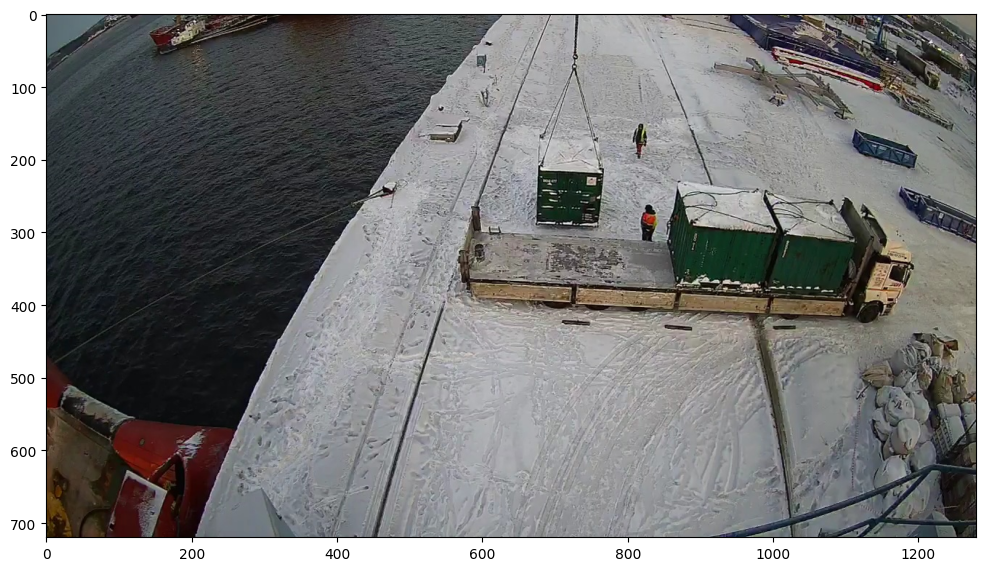

In [5]:
frame_num = 500

source = cv2.imread(f"./selected_video_frames/frame{frame_num}.jpg")

plot_img(source)

Ищем контейнеры


0: 384x640 1 Shipping container 6, 1495.8ms
Speed: 10.3ms preprocess, 1495.8ms inference, 1739.1ms postprocess per image at shape (1, 3, 384, 640)


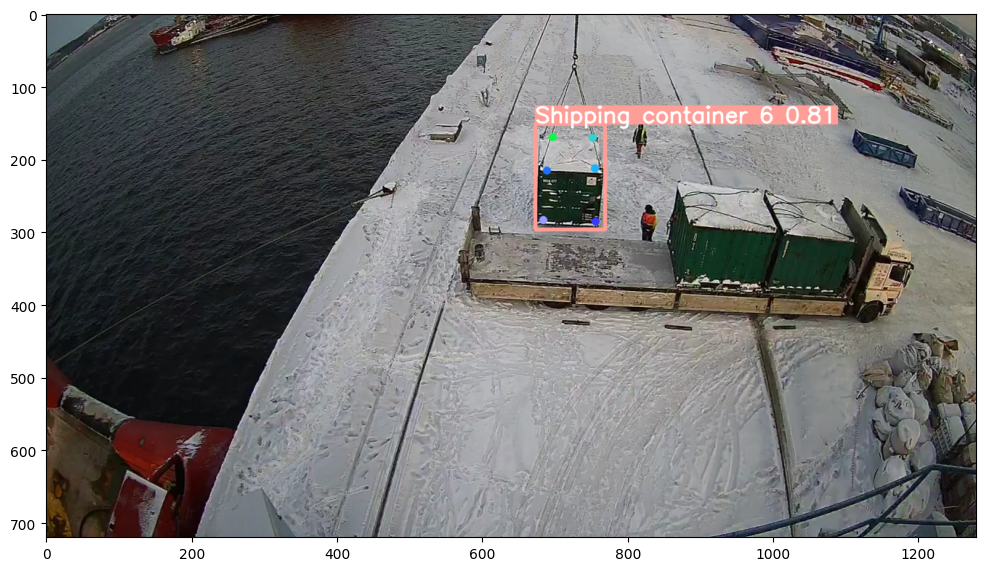

In [6]:
results = model(source, iou=0.5)
# for i in results:

plot_img(results[0].plot())

In [7]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: ultralytics.engine.results.Keypoints object
 masks: None
 names: {0: 'Shipping container 4', 1: 'Shipping container 6', 2: 'Shipping container 7'}
 obb: None
 orig_img: array([[[114, 108,  95],
         [114, 108,  95],
         [114, 108,  95],
         ...,
         [115, 129, 135],
         [115, 129, 135],
         [116, 130, 136]],
 
        [[114, 108,  95],
         [114, 108,  95],
         [114, 108,  95],
         ...,
         [115, 129, 135],
         [115, 129, 135],
         [115, 129, 135]],
 
        [[114, 108,  95],
         [114, 108,  95],
         [114, 108,  95],
         ...,
         [115, 129, 135],
         [115, 129, 135],
         [115, 129, 135]],
 
        ...,
 
        [[  9,  42,  57],
         [ 10,  43,  58],
         [  8,  39,  54],
         ...,
         [ 38,  39,  37],
         [ 64,  65,  61],
         [ 71,  72,  68]],
 
   

Смотрим ч у нас в боксе

In [8]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.])
conf: tensor([0.8077])
data: tensor([[673.0000, 152.0000, 769.0000, 297.0000,   0.8077,   1.0000]])
id: None
is_track: False
orig_shape: (720, 1280)
shape: torch.Size([1, 6])
xywh: tensor([[721.0000, 224.5000,  96.0000, 145.0000]])
xywhn: tensor([[0.5633, 0.3118, 0.0750, 0.2014]])
xyxy: tensor([[673., 152., 769., 297.]])
xyxyn: tensor([[0.5258, 0.2111, 0.6008, 0.4125]])

Обрезаем фотку

In [9]:
top_left = (np.array(results[0].boxes.xyxy[0, :2], dtype=int))
bottom_right = (np.array(results[0].boxes.xyxy[0, 2:],  dtype=int))

cropped_img = source[0:bottom_right[1], top_left[0]:bottom_right[0]]

In [10]:
# канаты
cropped_img = source[0:top_left[1], top_left[0]:bottom_right[0]]

In [11]:
# верхняя половина
cropped_img = source[0:(top_left[1]+bottom_right[1])//2, top_left[0]:bottom_right[0]]

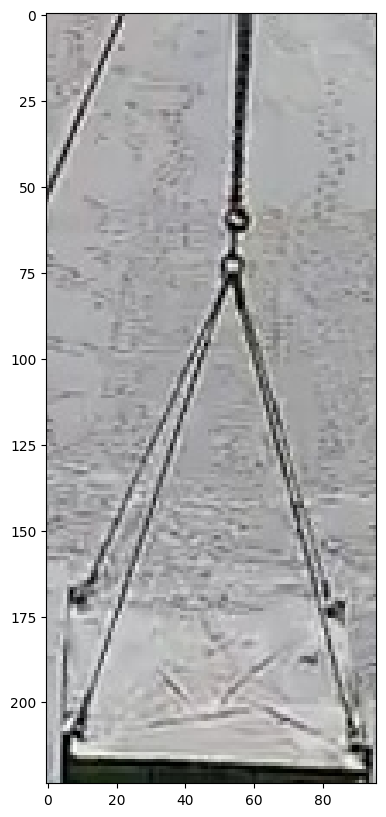

True

In [12]:
plot_img(cropped_img)
name_of_cropped_file = "cropped_img.jpg"
cv2.imwrite("cropped_img.jpg", cropped_img)

Ищем прямые на картинке 

In [13]:
import kornia as K
import kornia.feature as KF
import torch

In [14]:
torch_img1 = K.io.load_image(name_of_cropped_file, K.io.ImageLoadType.RGB32)[None, ...]
cropped_img.shape

(224, 96, 3)

In [15]:
# First, convert the images to gray scale
torch_img1_gray = K.color.rgb_to_grayscale(torch_img1)

In [16]:
sold2 = KF.SOLD2(pretrained=True, config=None)

In [17]:
%%capture
with torch.inference_mode():
    outputs = sold2(torch_img1_gray)

In [18]:
outputs.keys()

dict_keys(['junction_heatmap', 'line_heatmap', 'dense_desc', 'line_segments'])

In [19]:
line_seg = outputs["line_segments"][0]
desc = outputs["dense_desc"][0]

тут идет отрисовка двух картинок как в примере, переделывать лень

In [20]:
import copy

import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np


def plot_images(imgs, titles=None, cmaps="gray", dpi=100, size=6, pad=0.5):
    """Plot a set of images horizontally.
    Args:
        imgs: a list of NumPy or PyTorch images, RGB (H, W, 3) or mono (H, W).
        titles: a list of strings, as titles for each image.
        cmaps: colormaps for monochrome images.
    """
    n = len(imgs)
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n
    figsize = (size * n, size * 3 / 4) if size is not None else None
    fig, ax = plt.subplots(1, n, figsize=figsize, dpi=dpi)
    if n == 1:
        ax = [ax]
    for i in range(n):
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmaps[i]))
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        ax[i].set_axis_off()
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
        if titles:
            ax[i].set_title(titles[i])
    fig.tight_layout(pad=pad)


def plot_lines(lines, line_colors="orange", point_colors="cyan", ps=4, lw=2, indices=(0, 1)):
    """Plot lines and endpoints for existing images.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        colors: string, or list of list of tuples (one for each keypoints).
        ps: size of the keypoints as float pixels.
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    if not isinstance(line_colors, list):
        line_colors = [line_colors] * len(lines)
    if not isinstance(point_colors, list):
        point_colors = [point_colors] * len(lines)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l, lc, pc in zip(axes, lines, line_colors, point_colors):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=lc,
                linewidth=lw,
            )
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 1], pts[:, 0], c=pc, s=ps, linewidths=0, zorder=2)


def plot_color_line_matches(lines, lw=2, indices=(0, 1)):
    """Plot line matches for existing images with multiple colors.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    n_lines = len(lines[0])

    cmap = plt.get_cmap("nipy_spectral", lut=n_lines)
    colors = np.array([mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)])

    np.random.shuffle(colors)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=colors[i],
                linewidth=lw,
            )
            a.add_line(line)

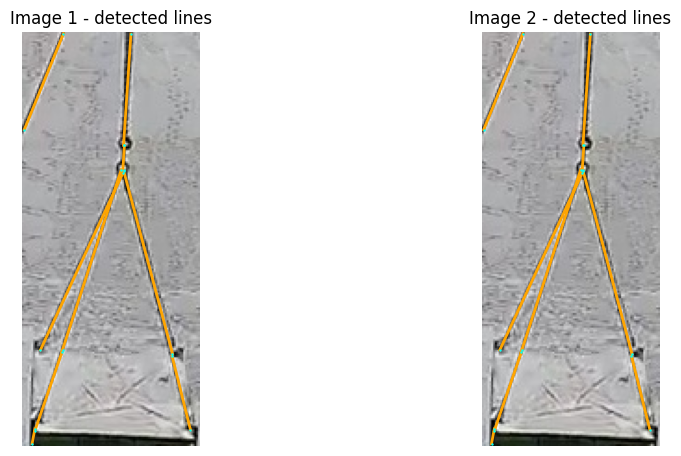

In [21]:
imgs_to_plot = [K.tensor_to_image(torch_img1), K.tensor_to_image(torch_img1)]
lines_to_plot = [line_seg.numpy(), line_seg.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})

Детектим углы

Shi-Tomasi method

/var/folders/8_/vxcsj2694gq22w6fgz7pz9vw0000gn/T/ipykernel_16673/2206780301.py:15: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


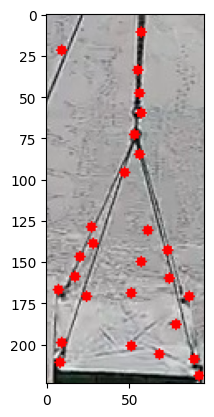

(<matplotlib.image.AxesImage at 0x130621550>, None)

In [22]:
# import the required library 
import numpy as np 
import cv2 
from matplotlib import pyplot as plt 
  
  
# read the image 
img = cv2.imread('cropped_img.jpg') 
  
# convert image to gray scale image 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  
# detect corners with the goodFeaturesToTrack function. 
corners = cv2.goodFeaturesToTrack(gray, 27, 0.01, 10) 
corners = np.int0(corners) 
  
# we iterate through each corner,  
# making a circle at each point that we think is a corner. 
for i in corners: 
    x, y = i.ravel() 
    cv2.circle(img, (x, y), 3, 255, -1) 
  
plt.imshow(img), plt.show() 

Harris Corner method

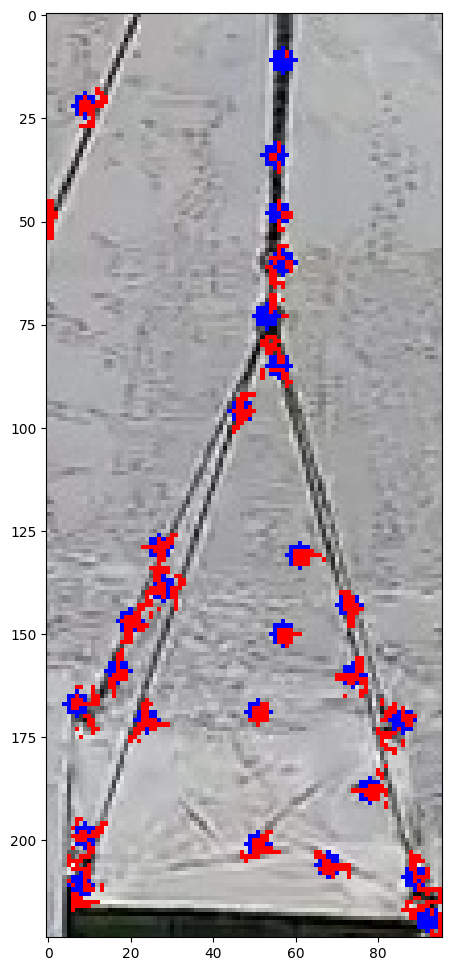

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to remove noise
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# Detect Harris corners
harris_corners = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

# Threshold the corners to get the strongest ones
threshold = 0.01 * harris_corners.max()
corner_image = np.copy(img)
 
# Mark the corners in red
corner_image[harris_corners > threshold] = [0, 0, 255] 
 
# Display the image with Harris corners marked in red
plt.figure(figsize = (16, 12))
plt.imshow(cv2.cvtColor(corner_image, cv2.COLOR_BGR2RGB))
plt.show()